# A Closer Look at Dimensionality Reduction with TriMap

**Important note:** Some of the larger figures (such as MNIST and Fashion MNIST visualizations) may not compile in the GitHub preview. Please consider downloading the colab to view all the figures properly.

**TriMap** is a dimensionality reduction method that forms a low-dimensional embedding of data by minimizing a contrastive loss over a set of triplets. The triplets are sampled from the original high-dimensional data representation and are weighted based on the distances between the (closer and farther) pairs of points. Although t-SNE and UMAP are excellent methods for forming low-dimensional embeddings, TriMap provides an alternative view of the data which is more representitive "globally". Specifically, TriMap is able to: 
1.   reflect the relative placement of the clusters in high-dimension,
2.   reveal possible outliers and anomolies in the data,
3.   generate embeddings that are more robust to certain transformations (see [here](https://arxiv.org/pdf/1803.00854.pdf) for more details).

This colab provides an alasysis of some of the results obtained with TriMap. The current implementation is in JAX and available at https://github.com/google-research/google-research/tree/master/trimap.

A Python + Numba implementation is available at https://github.com/eamid/trimap.

The method is described in https://arxiv.org/pdf/1910.00204.pdf.

Authors: Ehsan Amid (eamid@google.com) and Manfred K. Warmuth (manfred@google.com)

In [ ]:
import jax.random as random
import matplotlib.cm as cm
from matplotlib.lines import Line2D
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import numpy as np
from scipy.spatial.distance import cdist
from sklearn.datasets import make_s_curve
from sklearn.datasets import make_swiss_roll
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import trimap
import umap

from keras.datasets import mnist
from keras.datasets import fashion_mnist
import tensorflow_datasets as tfds

plt.rcParams["font.family"] = "serif"

#### Dataset loaders and plotting functions

In [ ]:
def load_coil100():
  examples, labels = [], []
  ds = tfds.load('coil100', split='train')
  ds = ds.batch(100, drop_remainder=False)
  iterator = iter(ds)
  for batch in iterator:
    examples.append(batch['image'])
    labels.append(batch['object_id'])
  examples = np.concatenate(examples, 0)
  labels = np.concatenate(labels)
  examples = np.reshape(examples, [examples.shape[0], -1])
  return examples.astype(np.float32), labels

def load_mnist():
  (train_examples, train_labels), (test_examples, test_labels) = mnist.load_data()
  train_examples = np.reshape(
      train_examples, (train_examples.shape[0], -1)).astype(np.float32)
  test_examples = np.reshape(
      test_examples, (test_examples.shape[0], -1)).astype(np.float32)
  return train_examples, train_labels, test_examples, test_labels

def load_fashion_mnist():
  (train_examples, train_labels), (
      test_examples, test_labels) = fashion_mnist.load_data()
  train_examples = np.reshape(
      train_examples, (train_examples.shape[0], -1)).astype(np.float32)
  test_examples = np.reshape(
      test_examples, (test_examples.shape[0], -1)).astype(np.float32)
  return train_examples, train_labels, test_examples, test_labels

def load_kmnist():
  examples, labels = [], []
  for split in ['train', 'test']:
    ds = tfds.load('kmnist', split=split)
    ds = ds.batch(100, drop_remainder=False)
    iterator = iter(ds)
    for batch in iterator:
      examples.append(batch['image'])
      labels.append(batch['label'])
  examples = np.concatenate(examples, 0)
  labels = np.concatenate(labels)
  examples = np.reshape(examples, [examples.shape[0], -1])
  return examples.astype(np.float32), labels


def scatter_plot_all_embeddings(
    embeddings, labels, methods, class_names,
    colormap='tab10', scale=0.2, figsize=6, show_legend=True):
  cmap = cm.get_cmap(colormap)
  cols = cmap(np.linspace(0., 1., len(class_names)))[:, :-1]
  num_methods = len(methods)
  _, axs = plt.subplots(
      1, num_methods, figsize=(figsize * num_methods, figsize))
  colors = cols[labels]
  for index, (embedding, method) in enumerate(zip(embeddings, methods)):
    axs[index].scatter(
        embedding[:, 0], embedding[:, 1], c=colors, s=scale, alpha=0.8)
    axs[index].set_xticks([])
    axs[index].set_yticks([])
    axs[index].set_title(method, fontsize=18)
    if show_legend and (index == (num_methods - 1)):
      legend_elements = []
      for label, name in enumerate(class_names):
        legend_elements.append(Line2D(
            [0], [0], marker='o', lw=0, markersize=10,
            color=cols[label], label=name, alpha=0.8))
      axs[index].legend(handles=legend_elements, fontsize=14)

def rgb2gray(image):
  red, green, blue = image[:, :, 0], image[:, :, 1], image[:, :, 2]
  gray = 0.2989 * red + 0.5870 * green + 0.1140 * blue
  return gray

def imscatter(ax, embedding, images, labels=None, figsize=10,
              colormap='tab10', subsample_ratio=1.0, zoom=1., flip=False,
              title='', thr=None, num_classes=10, seed=42):
  rng = np.random.RandomState(seed)
  cmap = cm.get_cmap(colormap)
  cols = np.reshape(
      cmap(np.linspace(0., 1., num_classes))[:, :-1], [-1, 1, 1, 3])
  if ax is None:
    _, ax = plt.subplots(figsize=(figsize, figsize))
  handles = []
  num_examples = embedding.shape[0]
  idx_perm = rng.permutation(num_examples)
  idx_perm = idx_perm[:int(num_examples * subsample_ratio)]
  for i in idx_perm:
    image = images[i]
    if len(image.shape) < 3:
      image = np.expand_dims(image, -1)
      image = np.tile(image, [1, 1, 4])
    else:
      mask = np.expand_dims(rgb2gray(image), -1)
      image = np.concatenate((image, mask), -1)
    if labels is not None:
      col = cols[labels[i]]
      image[:, :, :3] = image[:, :, :3] * (col * (1 - flip) + flip * (1. - col))
    if flip:
      image[:, :, :3] = 1. - image[:, :, :3]
    if thr is not None:
      mask = image[:, :, -1]
      mask[mask >= thr] = 1.0
      image[:, :, -1] = mask

    image = OffsetImage(image, zoom=zoom)
    ab = AnnotationBbox(image, embedding[i], xycoords='data', frameon=False)
    handles.append(ax.add_artist(ab))
  ax.update_datalim(embedding[idx_perm])
  ax.autoscale()
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_title(title, fontsize=18)
  return ax, handles

def discrepancy_matrix(data, labels, num_classes=10):
  means = np.array(
      [np.mean(data[labels==i], axis=0) for i in range(num_classes)])
  disc_mat = cdist(means, means)
  return disc_mat

def show_disc_mat(index, methods, disc_mats, title, class_names, figsize=8, top_k=2):
  figsize = (2.5 * figsize, figsize)
  _, ax = plt.subplots(figsize=figsize)
  class_aff = []
  disc_mat = []
  for mat in disc_mats:
    row = mat[index]
    row = row / np.max(row)
    idx_classes = np.argsort(row)
    class_aff.append(
        np.concatenate((idx_classes[1:top_k + 1], idx_classes[-top_k:])))
    disc_mat.append(row[class_aff[-1]])
  class_aff = np.array(class_aff)
  disc_mat = np.array(disc_mat)
  ax.imshow(disc_mat, interpolation ='none', aspect = 'auto',)
  for (j, i), val in np.ndenumerate(disc_mat):
    col = [1., 1., 1.] if i < top_k else [0., 0., 0.]
    val_str = '%s (%2.2f)' % (class_names[class_aff[j, i]], val)
    ax.text(i, j, val_str, ha='center',
            va='center', fontsize=16, color=col)
  y_ticks = np.arange(len(methods))
  ax.set_yticks(y_ticks)
  ax.set_yticklabels(methods, fontsize=16)
  
  ax.set_xticks([(top_k - 1.) / 2., (top_k - 1.) / 2. + top_k])
  ax.set_xticklabels(['closest-%d' % top_k, 'farthest-%d' %top_k], fontsize=16)
  ax.xaxis.set_tick_params(labeltop=True)
  ax.xaxis.set_tick_params(labelbottom=False)
  ax.set_title(title, fontsize=20)

## S-curve dataset

S-curve is a commonly used 3D dataset for evaluating dimensionality reduction and manifold learning methods. For our analysis, we use the [sklearn implementation](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_s_curve.html) and uniformly sample 10,000 points from the continuous manifold of the data.

In [ ]:
examples, labels = make_s_curve(n_samples=10000, random_state=0)

Let's first visualize the original dataset in 3D:

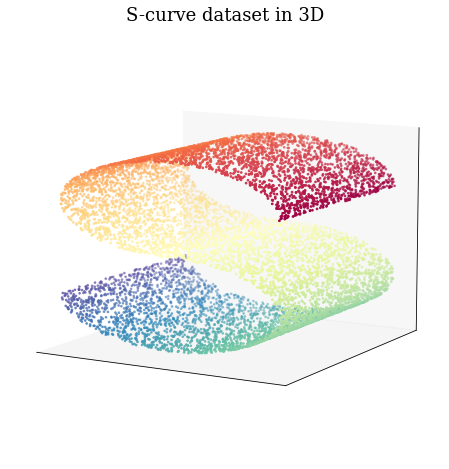

In [ ]:
fig = plt.figure(figsize=(8, 8), dpi=300)
ax = fig.add_subplot(projection='3d')
ax.scatter(examples[:, 0], examples[:, 1], examples[:, 2], s=3.0,
           c=labels, cmap=plt.cm.Spectral)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.view_init(10, -60)
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((0.97, 0.97, 0.97, 1.0))
ax.set_title('S-curve dataset in 3D', fontsize=18)
plt.show()

The dataset looks like a rectangular surface bent in the shape of an 'S' symbol.

We find the 2D embeddings of the dataset using t-SNE, UMAP, TriMap, and PCA:

In [ ]:
# t-SNE
emb_scurve_tsne = TSNE().fit_transform(examples)

# UMAP
emb_scurve_umap = umap.UMAP().fit_transform(examples)

# TriMap
key = random.PRNGKey(123)
emb_scurve_trimap = trimap.transform(key, examples)

# PCA
emb_scurve_pca = PCA(n_components=2).fit_transform(examples)

And plot the embeddings:

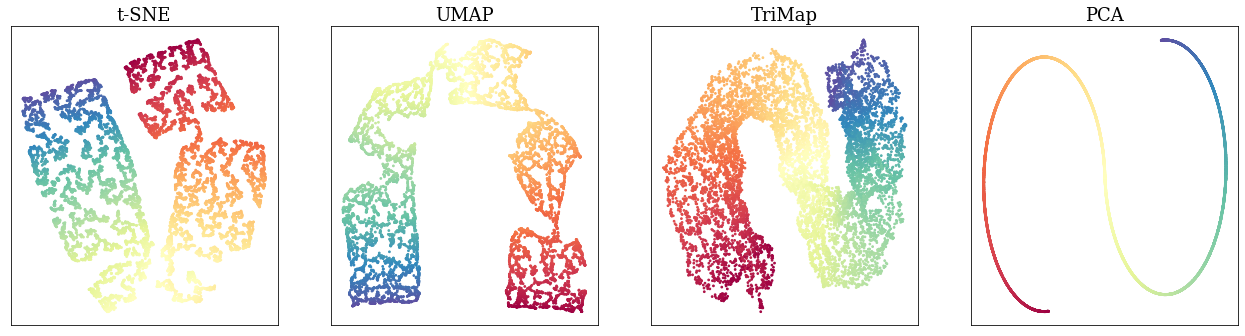

In [ ]:
embeddings = [emb_scurve_tsne, emb_scurve_umap, emb_scurve_trimap, emb_scurve_pca]
methods = ['t-SNE', 'UMAP', 'TriMap', 'PCA']

figsize = 5.5
_, axs = plt.subplots(
      1, len(methods), figsize=(figsize * len(methods), figsize))

for ax, embedding, method in zip(axs, embeddings, methods):
  ax.scatter(
        embedding[:, 0], embedding[:, 1], c=labels, s=3.0,
        cmap=plt.cm.Spectral)
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_title(method, fontsize=18)

Comparing the 2D embeddings to the original 3D dataset, we observe that the shape of the S-curve is preserved in the TriMap and PCA results. Additionally, TriMap reveals the rectangular shape of the unrolled surface while PCA is only able to recover the overall shape.

## Swiss Roll dataset

Swiss roll is another commonly used 3D dataset for evaluating dimensionality reduction methods. We use the [sklearn implementation](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_swiss_roll.html) to sample 10,000 points uniformly from the data manifold.

In [ ]:
examples, labels = make_swiss_roll(n_samples=10000, random_state=0)

Here, we visualize the original 3D dataset:

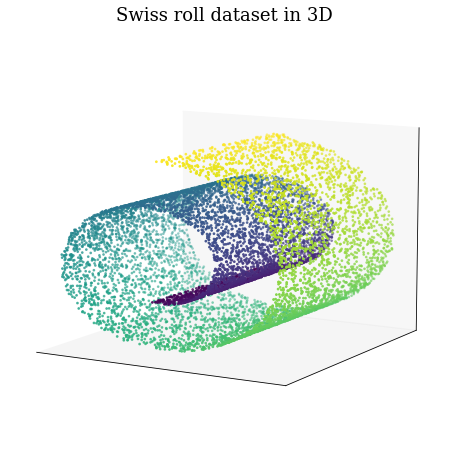

In [ ]:
fig = plt.figure(figsize=(8, 8), dpi=300)
ax = fig.add_subplot(projection='3d')
ax.scatter(examples[:, 0], examples[:, 1], examples[:, 2], s=3.0,
           c=labels)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.view_init(10, -60)
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((0.97, 0.97, 0.97, 1.0))
ax.set_title('Swiss roll dataset in 3D', fontsize=18)
plt.show()

We now calulate and plot the 2D embeddings:

In [ ]:
# t-SNE
emb_swissroll_tsne = TSNE().fit_transform(examples)

# UMAP
emb_swissroll_umap = umap.UMAP().fit_transform(examples)

# TriMap
key = random.PRNGKey(123)
emb_swissroll_trimap = trimap.transform(key, examples)

# PCA
emb_swissroll_pca = PCA(n_components=2).fit_transform(examples)

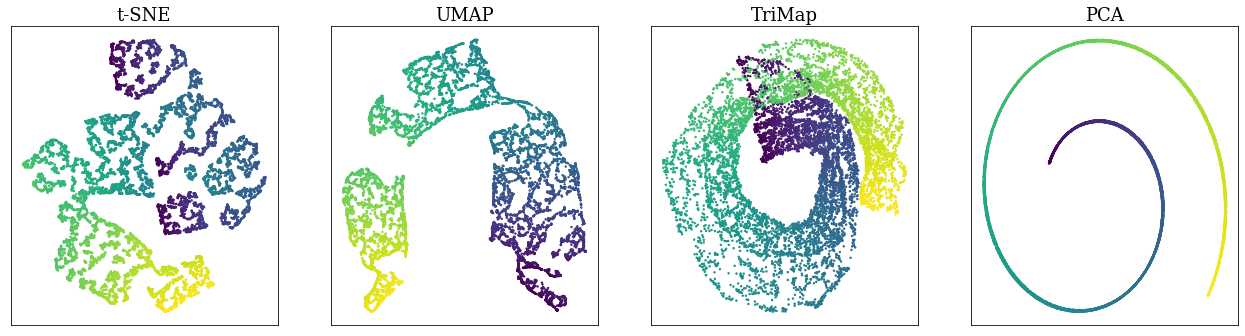

In [ ]:
embeddings = [emb_swissroll_tsne, emb_swissroll_umap, emb_swissroll_trimap, emb_swissroll_pca]
methods = ['t-SNE', 'UMAP', 'TriMap', 'PCA']

figsize = 5.5
_, axs = plt.subplots(
      1, len(methods), figsize=(figsize * len(methods), figsize))

for ax, embedding, method in zip(axs, embeddings, methods):
  ax.scatter(
        embedding[:, 0], embedding[:, 1], c=labels, s=2.0)
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_title(method, fontsize=18)

Similar to the previous results, TriMap is able to preserve the continuous and curved surface of the swiss roll dataset better than the other methods.

## MNIST digits dataset

[MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database) contains 70,000 images of handwritten digits of size 28 X 28. Due to various handwriting styles, MNIST naturally contains variations of each digit, e.g., different ways of writing '7', or different orientations of '1'.

<img src='https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png'>

##### We load the data and calculate the embeddings:

In [ ]:
# load MNSIT
train_examples, train_labels, test_examples, test_labels = load_mnist()

# combine the train and test data
examples = np.concatenate((train_examples, test_examples), 0)
labels = np.concatenate((train_labels, test_labels))

# t-SNE
emb_mnist_tsne = TSNE().fit_transform(examples)

# UMAP
emb_mnist_umap = umap.UMAP().fit_transform(examples)

# TriMap
key = random.PRNGKey(123)
emb_mnist_trimap = trimap.transform(key, examples)

# PCA
emb_mnist_pca = PCA(n_components=2).fit_transform(examples)

##### We plot the embeddings:

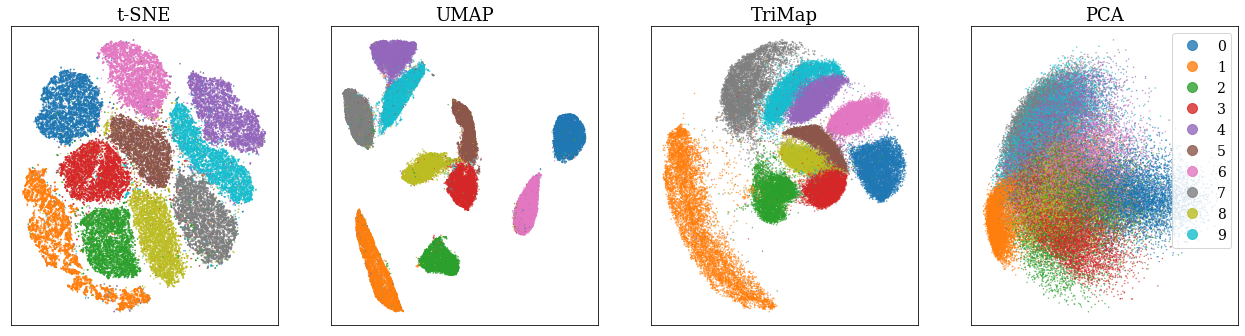

In [ ]:
embeddings = [emb_mnist_tsne, emb_mnist_umap, emb_mnist_trimap, emb_mnist_pca]
methods = ['t-SNE', 'UMAP', 'TriMap', 'PCA']
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
scatter_plot_all_embeddings(
    embeddings, labels, methods, class_names, colormap='tab10', figsize=5.5)

The clusters of digits are arranged similarly in UMAP and TriMap. However, the TriMap result overall looks more similar to PCA (which is a global projection of the data along the [highest variance directions](https://en.wikipedia.org/wiki/Principal_component_analysis#/media/File:GaussianScatterPCA.svg)). The t-SNE result contains less structure in terms of cluster similarity. 

Additionally, TriMap places the cluster of '1's farther away from the rest of the clusters. Also, the cluster of '1's looks more elongated than the others. Moreover, TriMap reveals many points that are in-between the cluster of '1's and the clusters of '2's and '7's. Let's look at the scatter plotted digit images to inverstigate this further.

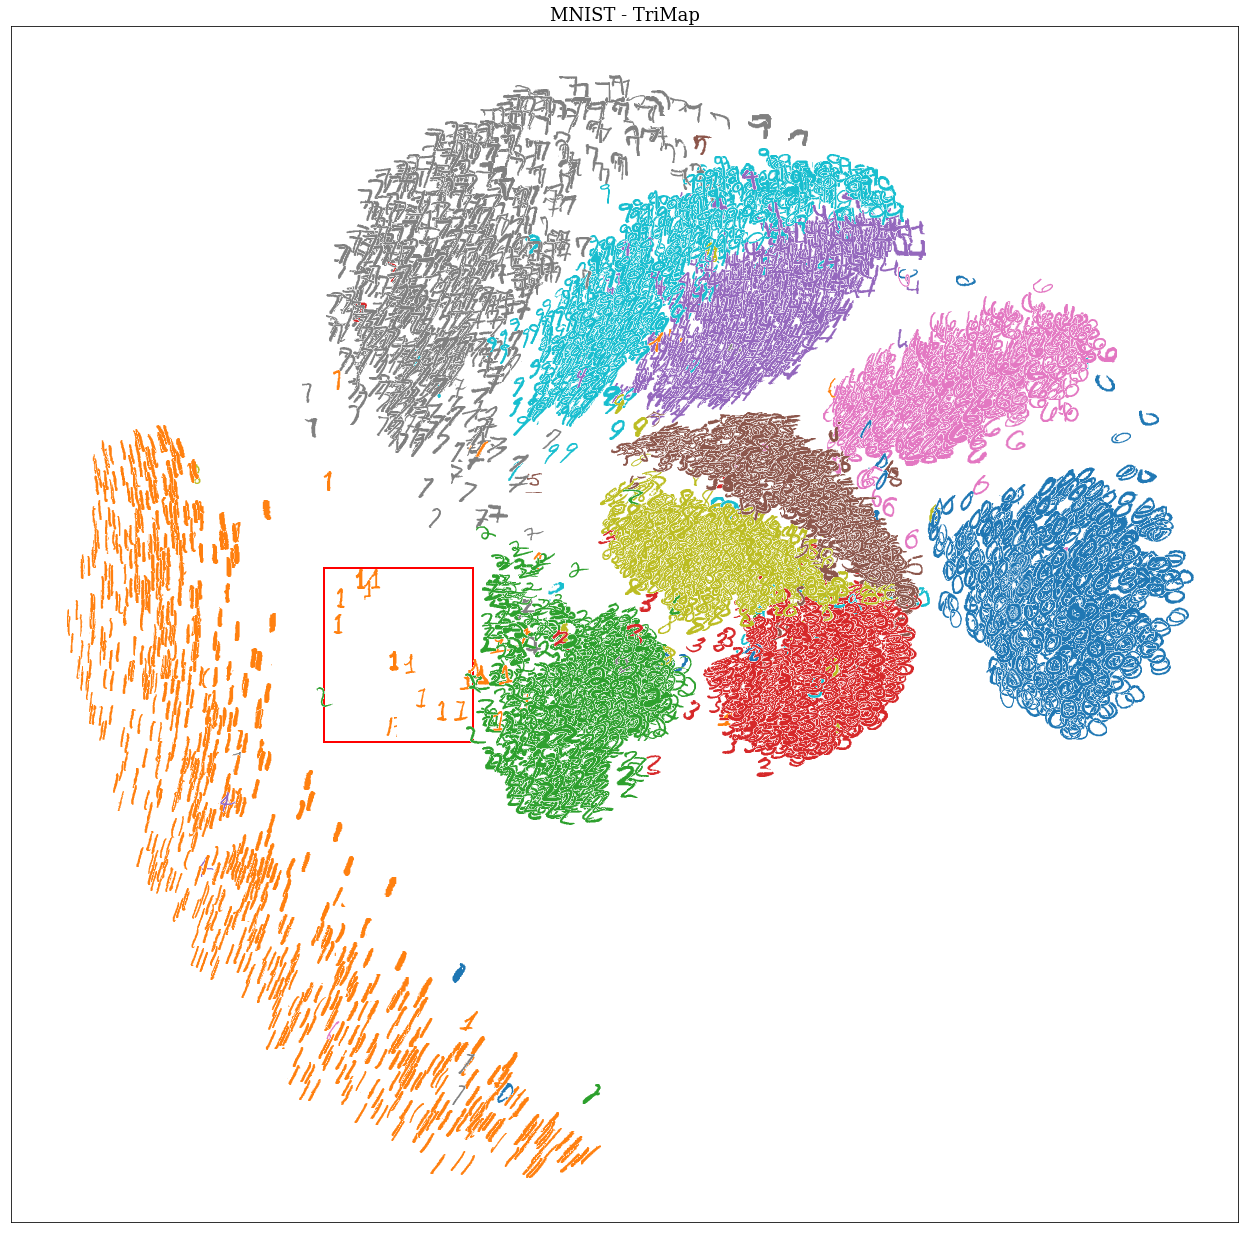

In [ ]:
ax = None
images = np.reshape(examples, [-1, 28, 28]) / 255.0
ax, _ = imscatter(ax, np.array(emb_mnist_trimap), images, labels=labels, figsize=22,
              subsample_ratio=0.1, flip=True, thr=0.1, seed=1335,
              title='MNIST - TriMap')
rect = patches.Rectangle((55, 65), 10, 12, linewidth=2., edgecolor='r', facecolor='none')
_ = ax.add_patch(rect)

Here, we plot only 10% of the images to avoid clutter. We see that the skewedness direction in the cluster of '1's corresponds to different orinetations of handwritings. We also observe that the few instances of '1's that lie in between clusters of '2's and '7's (marked by the red rectangle) correspond to the [European-style](https://www.quora.com/Handwriting-Why-do-Europeans-write-1s-with-a-long-slash-at-the-top) of writing '1' with a slash on top. This variation makes these instances less distinguishable from '2' and '7'. Let's check where the same instances of *slashed* '1's are placed in the t-SNE and UMAP results.

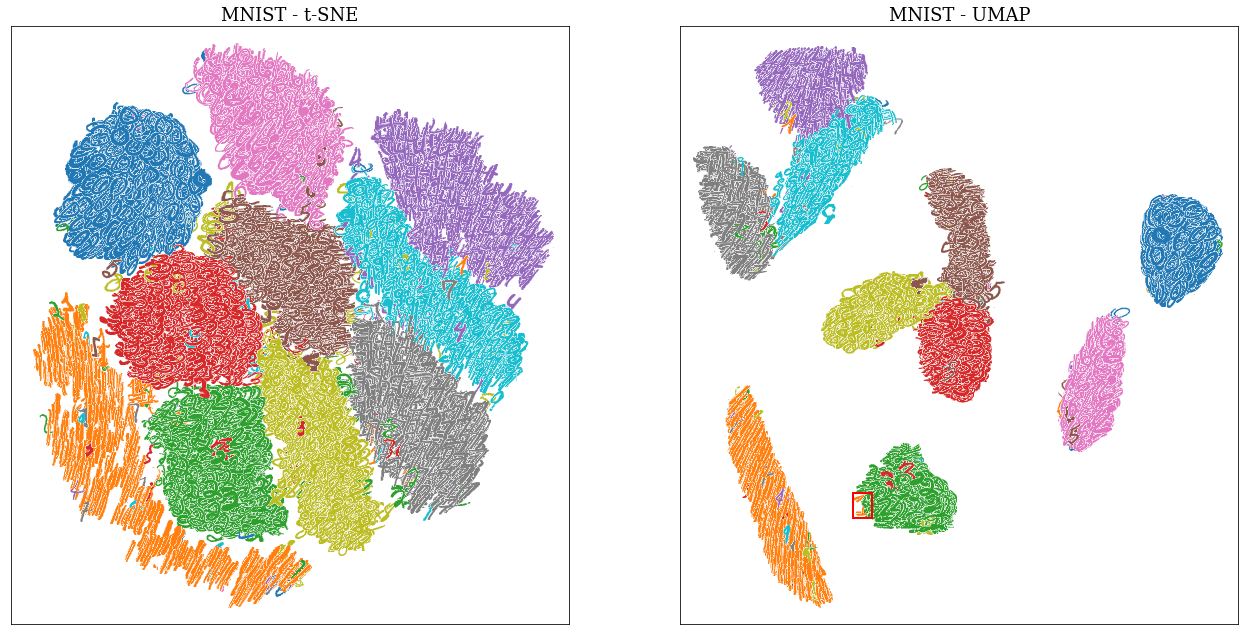

In [ ]:
figsize = 11
_, axs = plt.subplots(1, 2, figsize=(figsize * 2, figsize))
for ax, embedding, method in zip(
    axs, [emb_mnist_tsne, emb_mnist_umap], ['t-SNE', 'UMAP']):
  ax, _ = imscatter(ax, np.array(embedding), images, labels=labels, figsize=figsize,
                subsample_ratio=0.1, flip=True, thr=0.1, seed=1335,
                title=f'MNIST - {method}')
  if method == 'UMAP':
    rect = patches.Rectangle((0.65, -1.45), 0.8, 0.9, linewidth=2., edgecolor='r', facecolor='none', zorder=10)
    _ = ax.add_patch(rect)


We see from the UMAP plot that these slashed '1' digits are now absorbed into either clusters of '2's or '7's. Thus, although UMAP provides "cleaner" and better separated clusters than TriMap, the *in-between* *clusters* instances are absorbed into the closer clusters.

## Fashion MNIST clothing images dataset

[Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) is an alternative to the MNIST dataset for machine learning (ML) applications. Similar to MNIST, it contains 70,000 examples of 28 X 28 images from 10 classes. The classes correspond to different clothing items such as 'Dress' and 'Sneaker'. Fashion MNIST was mainly developed because MNIST is too easy for the more recent ML models to classify. Specifically, the clusters in Fashion MNIST are less separated and harder to distinguish than the MNIST clusters.

<img src='https://github.com/zalandoresearch/fashion-mnist/blob/master/doc/img/fashion-mnist-sprite.png?raw=true'>

In [ ]:
# load Fashion MNSIT
train_examples, train_labels, test_examples, test_labels = load_fashion_mnist()

# combine the train and test data
examples = np.concatenate((train_examples, test_examples), 0)
labels = np.concatenate((train_labels, test_labels))

# t-SNE
emb_fmnist_tsne = TSNE().fit_transform(examples)

# UMAP
emb_fmnist_umap = umap.UMAP().fit_transform(examples)

# TriMap
key = random.PRNGKey(123)
emb_fmnist_trimap = trimap.transform(key, examples)

# PCA
emb_fmnist_pca = PCA(n_components=2).fit_transform(examples)

##### Let's again plot the 2D embeddings of the data:

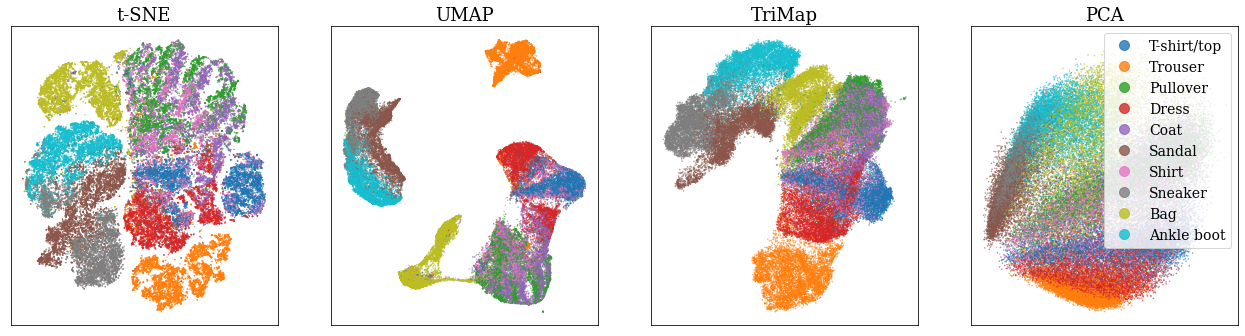

In [ ]:
embeddings = [emb_fmnist_tsne, emb_fmnist_umap, emb_fmnist_trimap, emb_fmnist_pca]
methods = ['t-SNE', 'UMAP', 'TriMap', 'PCA']
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal',
               'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
scatter_plot_all_embeddings(
    embeddings, labels, methods, class_names, colormap='tab10', figsize=5.5)

As we expected, the clusters are less separated compared to the MNIST plots. For instance, the clusters of 'Pullover', 'Shirt', and 'Coat' are highly entangled. Interestingly, unlike t-SNE and UMAP, TriMap provides a more connected (C-shaped) representation of the data. Specifically, compared to the UMAP result, it is evident that clusters of 'Trouser' and 'Dress' in TriMap are placed much closer to each other with a softer transition. To validate this observation, we calculate the pairwise distance matrix between the cluster centers in the original data and the 2D embeddings.

In [ ]:
disc_mat_orig = discrepancy_matrix(examples, labels)

disc_mat_pca = discrepancy_matrix(emb_fmnist_pca , labels)
disc_mat_tsne = discrepancy_matrix(emb_fmnist_tsne, labels)
disc_mat_umap = discrepancy_matrix(emb_fmnist_umap, labels)
disc_mat_trimap = discrepancy_matrix(emb_fmnist_trimap, labels)

Let's now check the closest and farthest two clusters to 'Trouser' in each case. Here, we also show the normalized pairwise distance (pairwise distances divided by the maximum pairwise distance) form 'Trouser' for each embedding.

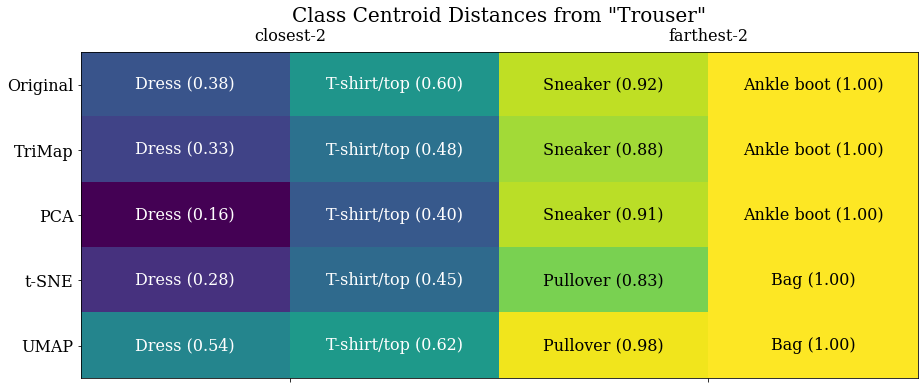

In [ ]:
figsize = 6
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal',
               'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
methods = ['Original', 'TriMap', 'PCA', 't-SNE', 'UMAP']
disc_mats = [disc_mat_orig, disc_mat_trimap, disc_mat_pca, disc_mat_tsne, disc_mat_umap]
index = 1
show_disc_mat(index, methods, disc_mats, 'Class Centroid Distances from "%s"' % class_names[index], class_names, figsize=figsize, top_k=2)

We see that the closest and farthest two clusters to 'Trouser' are only consistent in the PCA and TriMap embeddings. Interestingly, the distance between 'Trouser' and 'Dress' is in fact small and much closer between the original data and TriMap than the rest of the methods. We can also verify this visually by plotting the original images on the TriMap embedding:

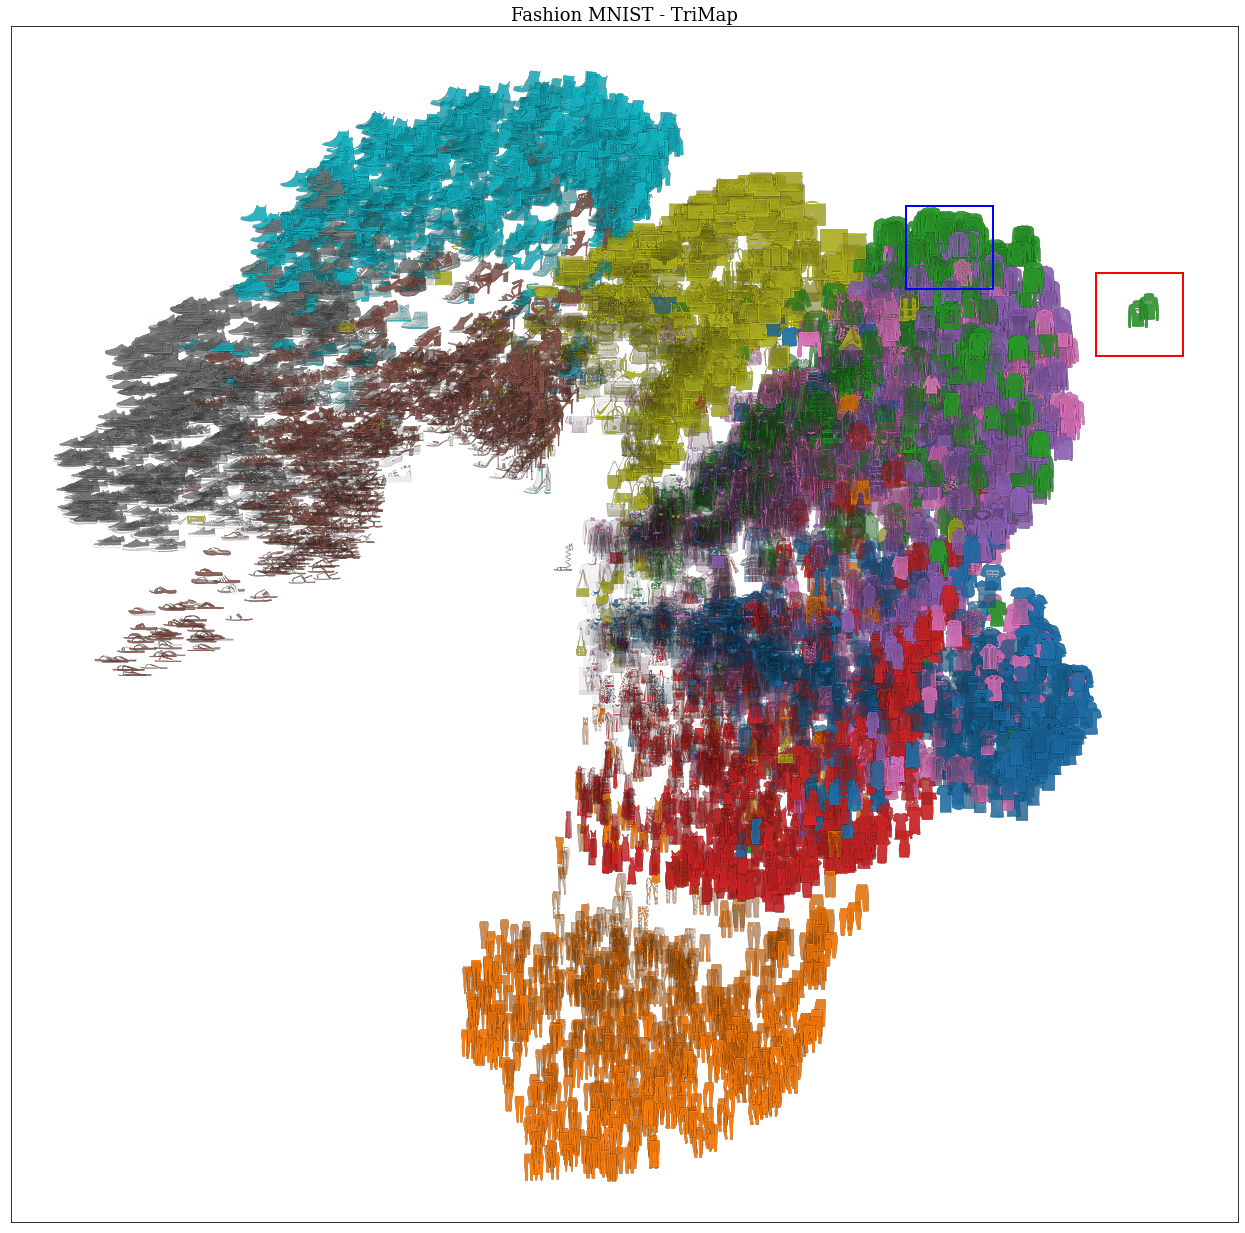

In [ ]:
ax = None
images = np.reshape(examples, [-1, 28, 28]) / 255.0
ax, _ = imscatter(ax, np.array(emb_fmnist_trimap), images, labels=labels, figsize=22,
              subsample_ratio=0.1, flip=False, thr=None, seed=1335,
              title='Fashion MNIST - TriMap')
rect_red = patches.Rectangle((105, 90), 5, 5, linewidth=2., edgecolor='r', facecolor='none')
rect_blue = patches.Rectangle((94, 94), 5, 5, linewidth=2., edgecolor='b', facecolor='none', zorder=10)
_ = ax.add_patch(rect_red)
_ = ax.add_patch(rect_blue)

As we can see, the transition between 'Trouser' and 'Dress' is much smoother and closer to the original data representation in TriMap. (Here, we show 10% of the images to avoid cluetter.) Also, the images in the center part of the C-shaped embedding are those that more transparent.

Another inetersting observation is the existence of a few outlier 'Pullover' examples (marked by the red rectangle) that are located farther away from the rest of 'Pullover's. Next, we compare these outliers to the another set of 'Pullover' examples (marked by the blue rectangle) that are closer to the cluster of 'Bag'.

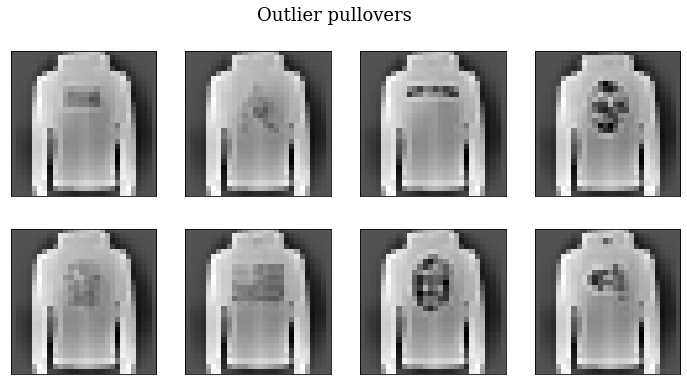

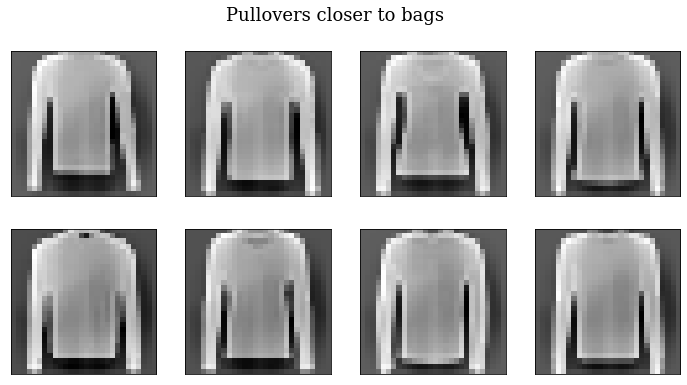

In [ ]:
sorted_class_pullover = np.argsort(emb_fmnist_trimap[:, 0])  # sort with respect to the x-axis 
sorted_class_pullover = sorted_class_pullover[labels[sorted_class_pullover] == 2]
xvals, yvals = emb_fmnist_trimap[sorted_class_pullover, 0], emb_fmnist_trimap[sorted_class_pullover, 1]
middle_points = sorted_class_pullover[np.logical_and(
    xvals > 95, np.logical_and(xvals < 100, yvals > 98))]

fig, axes = plt.subplots(2, ncols=4, figsize=(12, 6))
for i, ax in enumerate(axes.flatten()):
  image = np.reshape(examples[sorted_class_pullover[-1-i]], [28, 28])
  ax.imshow(image, cmap='gray')
  ax.set_xticks([])
  ax.set_yticks([])
fig.suptitle('Outlier pullovers', fontsize=18)
plt.show()
fig, axes = plt.subplots(2, ncols=4, figsize=(12, 6))
for i, ax in enumerate(axes.flatten()):
  image = np.reshape(examples[middle_points[i]], [28, 28])
  ax.imshow(image, cmap='gray')
  ax.set_xticks([])
  ax.set_yticks([])
fig.suptitle('Pullovers closer to bags', fontsize=18)
plt.show()

Seemingly, the main reason for outlier 'Pullover' examples are the large prints in the image, whereas the other examples have a solid surface. These observations are less evident from the t-SNE and UMAP results:

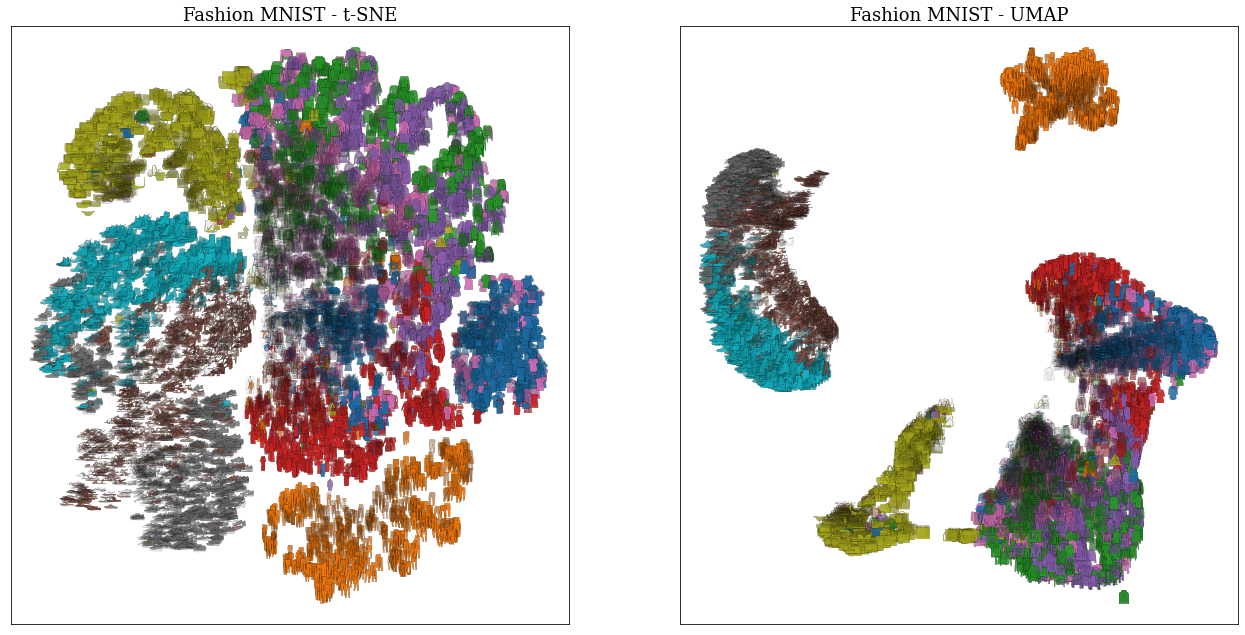

In [ ]:
figsize = 11
_, axs = plt.subplots(1, 2, figsize=(figsize * 2, figsize))
for ax, embedding, method in zip(
    axs, [emb_fmnist_tsne, emb_fmnist_umap], ['t-SNE', 'UMAP']):
  _ = imscatter(ax, np.array(embedding), images, labels=labels, figsize=figsize,
                subsample_ratio=0.1, flip=False, thr=None, seed=1335, zoom=0.5,
                title=f'Fashion MNIST - {method}')

## More Examples: [Kuzushiji-MNIST](http://codh.rois.ac.jp/kmnist/index.html.en#:~:text=Kuzushiji%2DMNIST%20is%20a%20drop,Hiragana%20when%20creating%20Kuzushiji%2DMNIST.) Japenese alphabet dataset

In [ ]:
# load KMNSIT
examples, labels = load_kmnist()

# t-SNE
emb_kmnist_tsne = TSNE().fit_transform(examples)

# UMAP
emb_kmnist_umap = umap.UMAP().fit_transform(examples)

# TriMap
key = random.PRNGKey(123)
emb_kmnist_trimap = trimap.transform(key, examples)

# PCA
emb_kmnist_pca = PCA(n_components=2).fit_transform(examples)

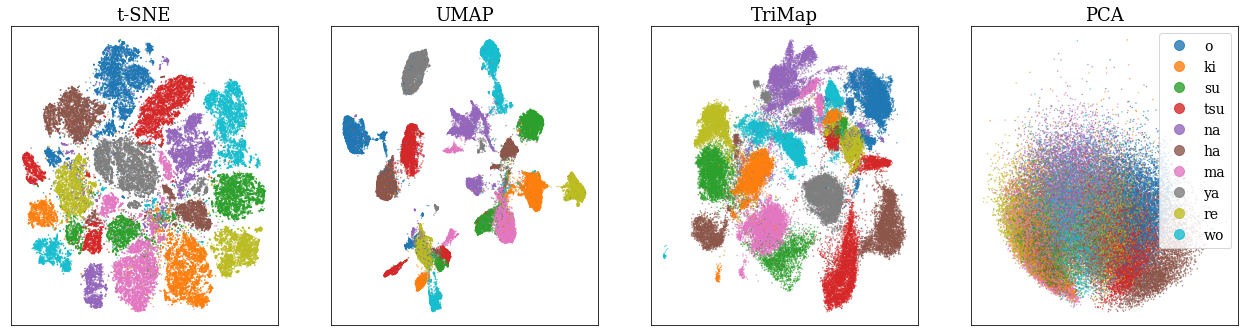

In [ ]:
embeddings = [emb_kmnist_tsne, emb_kmnist_umap, emb_kmnist_trimap, emb_kmnist_pca]
methods = ['t-SNE', 'UMAP', 'TriMap', 'PCA']
class_names = ['o', 'ki', 'su', 'tsu', 'na', 'ha', 'ma', 'ya', 're', 'wo']
scatter_plot_all_embeddings(
    embeddings, labels, methods, class_names, colormap='tab10', figsize=5.5)

## More Examples: [COIL-100 dataset](https://www.cs.columbia.edu/CAVE/software/softlib/coil-100.php) of objects at different rotations


In [ ]:
# load COIL-100
examples, labels = load_coil100()

# t-SNE
emb_coil100_tsne = TSNE().fit_transform(examples)

# UMAP
emb_coil100_umap = umap.UMAP().fit_transform(examples)

# TriMap
key = random.PRNGKey(123)
emb_coil100_trimap = trimap.transform(key, examples)

# PCA
emb_coil100_pca = PCA(n_components=2).fit_transform(examples)

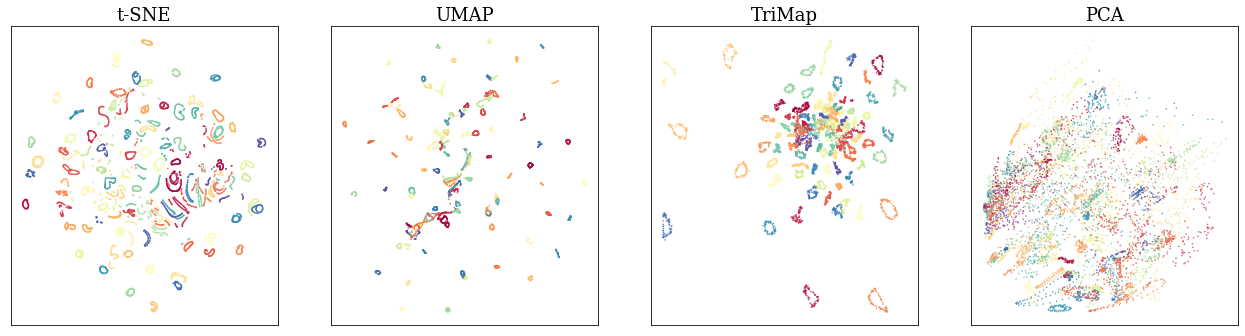

In [ ]:
embeddings = [emb_coil100_tsne, emb_coil100_umap, emb_coil100_trimap, emb_coil100_pca]
methods = ['t-SNE', 'UMAP', 'TriMap', 'PCA']
class_names = np.arange(100)
scatter_plot_all_embeddings(
    embeddings, labels, methods, class_names, colormap='Spectral', figsize=5.5,
    show_legend=False, scale=0.3)

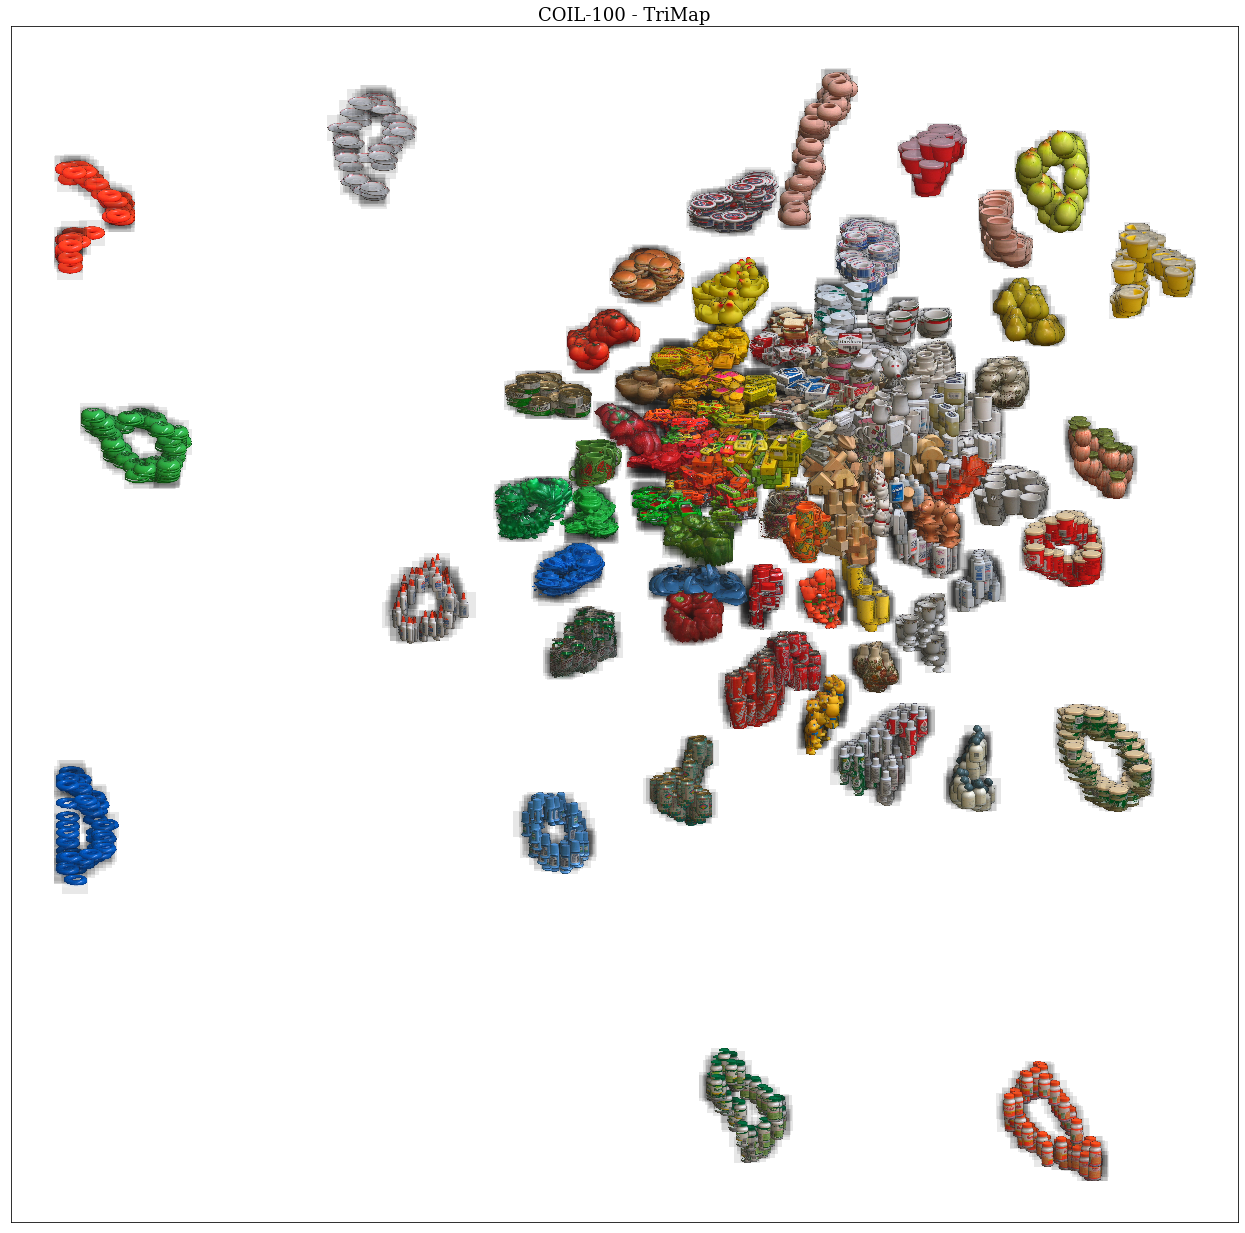

In [ ]:
ax = None
images = np.reshape(examples, [-1, 128, 128, 3])
images = (images - np.min(images)) / (np.max(images) - np.min(images))
_ = imscatter(ax, np.array(emb_coil100_trimap), images, labels=None, figsize=22,
              subsample_ratio=1.0, flip=False, thr=0.18, seed=1335, zoom=0.2,
              title='COIL-100 - TriMap')